# FVCOM–ERSEM Visualisation Notebook (using `fvcomersem-viz`)

Welcome! This notebook demonstrates how to make clear, reproducible figures from **FVCOM–ERSEM** model output using the lightweight, *function-first* plotting toolkit **`fvcomersem-viz`**. The package keeps the API simple (plain Python functions, no GUI) and ships with focused plotting routines and helpers so you can go from raw NetCDF to publication-ready graphics quickly.

---

## What you’ll learn here

* How to point the toolkit at your **FVCOM output** (single file or collections).
* How to make:

  * **Map plots** of surface fields with optional regional overlays.
  * **Hovmöller diagrams** at fixed stations (sigma or fixed-z).
  * **Time series** and seasonal/period **composites**.
  * **KDE stoichiometry** panels (e.g., N:C / P:C vs variables at surface/bottom).
* How to use variable **groups/composites** (e.g., `chl`, `phyto`, `DOC`) via simple algebraic expressions.
* How to control time windows (months/years/date ranges) and depth slices (surface, bottom, fixed-z, depth-avg).

---

## What this notebook expects

* **Model data:** FVCOM–ERSEM NetCDF output (e.g., daily or hourly files).
* **Optional region definitions:** shapefiles or CSV polygons for domain/central/boxes.
* **Optional station list:** for point-based Hovmöller/series.

> If your paths differ from the examples, just edit the `BASE_DIR`, `FILE_PATTERN`, and any region/station paths in the “Setup” cells.

---

## Package at a glance

* **Name:** `fvcomersem-viz`
* **Design:** function-first (import functions and call them), no CLI/GUI
* **Key modules:**

  * `plots/maps.py` – maps of scalar fields on the FVCOM grid
  * `plots/hovmoller.py` – along-time/along-depth sections at stations
  * `plots/timeseries.py` – single or multi-variable time series & composites
  * `plots/kde_stoichiometry.py` – 2×2 stoichiometry panels
  * `plots/composition.py`, - visualises the composition of grouped communities (e.g., phytoplankton or zooplankton) as relative shares across time/space.
  * `plots/curves.py` - builds reusable diagnostic curves (scatter/KDE/fits) and shared styling used across stoichiometry and time-series plot
  * `io.py`, `regions.py`, `utils.py`, `plot.py` – data discovery, time/depth filters, masks, labels, plotting functions

---

## Requirements (tested versions)

* Python ≥ 3.9 (3.11 recommended)
* Core stack: `numpy`, `pandas`, `xarray`, `matplotlib`, `netCDF4`, `cftime`, `scipy`
* Geospatial (for regional masks/overlays): `geopandas`, `shapely`, `pyproj`, `rtree` (optional but recommended)
* Performance (optional): `dask[array]`


##  Installation

Create a clean environment with FVCOM-compatible dependencies:

>```bash
>conda create -n fviz python=3.11 geopandas shapely pyproj rtree -c conda-forge
>conda activate fviz
>```

 If working locally, you can install in editable mode:

> ```bash
> pip install -e .
> ```

---

## Typical workflow used in this notebook

1. **Setup paths & imports**

   ```python
   from fvcomersemviz.plots import maps, hovmoller, timeseries
   from fvcomersemviz.io import filter_time
   ```
2. **Load data** (single file or pattern), select **time window** and **depth slice**.
3. **Plot** using a purpose-built function (e.g., `maps.plot_surface_field(...)`), tweak labels, save.
4. **Repeat** for stations/regions/variables as needed.

---

## Reproducibility & citations

Please cite **`fvcomersem-viz`** alongside the relevant FVCOM/ERSEM model references when using figures generated from this toolkit. The notebook cells are structured so outputs are reproducible from a minimal set of inputs (file paths, variable names, time/depth selections, and optional region/station definitions).

---

## Core capabilities

Map visualisation:
Create horizontal maps of surface or depth-averaged fields, optionally masked by regions or polygons.
Useful for showing spatial patterns (e.g., chlorophyll, nutrients, oxygen).

Hovmöller diagrams:
Plot time-depth (sigma or fixed-z) sections at selected stations or regions to reveal seasonal and interannual variability.

Time series and composites:
Produce single or multi-variable time series, monthly/seasonal climatologies, and box-region averages.

Stoichiometry and diagnostics:
Generate 2×2 KDE panels or scatter plots to explore relationships between model tracers (e.g., N:C, P:C ratios, oxygen vs temperature).

Variable groups and expressions:
Access groups like phyto, zoo, nutrients, or define on-the-fly algebraic combinations (e.g., total chlorophyll or N:P).

## Typical use cases

Generating consistent visual outputs across multiple FVCOM–ERSEM experiments.

Producing diagnostics or summary figures for reports and publications.

Quickly inspecting model fields without building a full analysis pipeline.

Supporting automated post-processing workflows for long-term simulations.

**Next:** run the setup cell below to configure your data paths and make your first map plot.


# Setup

This section builds a conda enmviuronment and installs the packpage with all its required dependencies. 



### (Optional) Install locally in editable mode 
uncomment below to create a conda env and install the package in editable mode

In [ ]:
## If you're working locally and have the repo checked out:
#!conda create -y -n fvcomersemviz python=3.11 geopandas shapely pyproj rtree -c conda-forge
#!conda run -n fvcomersemviz python3 -m pip install -e ..
#!conda run -n fvcomersemviz python3 -m pip install numpy pandas xarray matplotlib netCDF4 cftime scipy dask geopandas shapely pyproj rtree ipykernel notebook
#!conda run -n fvcomersemviz python3 -m ipykernel install --user --name fvcomersemviz --display-name "Python (fvcomersemviz)"

# Save kernelspec into this notebook so it opens with Python (fviz) next time
#from IPython.display import display, Javascript
#display(Javascript("""
#if (typeof Jupyter !== 'undefined' && Jupyter.notebook) {
#  Jupyter.notebook.metadata.kernelspec = {
#    "display_name": "Python (fvcomersemviz)",
#    "language": "python",
#    "name": "fvcomersemviz"
#  };
#  Jupyter.notebook.save_notebook();
#  alert("Saved. Now use: Kernel → Change kernel → Python (fviz) to continue in that env.");
#}
#"""))

### Switching to the new Conda environment

The environment fviz has now been created, dependencies installed, and a Jupyter kernel registered as “Python (fviz)”.
To continue working inside that environment:

In the Jupyter menu bar, go to:
Kernel → Change kernel → Python (fviz)

Wait a few seconds for the notebook to reconnect — the kernel name in the top-right corner should now read Python (fviz).

Once switched, all imports and plotting functions will run inside the new Conda environment you just created

We can check everything has installed correctly by running the cell below:

In [ ]:
!conda run -n fvcomersemviz python3 -u ../tests/check_install.py

## Setting up your data paths

In this section, we tell the notebook where to find the FVCOM–ERSEM model output and where to save plots.

You can configure everything by editing a few key variables:

BASE_DIR → the folder where your FVCOM–ERSEM NetCDF files live.
Example:
>```python
>BASE_DIR = "/data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var"
>```

This should point to the root of your model output directory — the location of all NETCDF output files.

FILE_PATTERN → the naming pattern for your files.
Example:
>```python
>FILE_PATTERN = "netcdf_00??.nc"
>```

This pattern uses wildcards (? or *) to match all relevant NetCDF files you want to load together.
For instance, this would match:

netcdf_0001.nc, netcdf_0002.nc, netcdf_0003.nc, ...


FIG_DIR → the directory where all output plots will be saved.
Example:
>```python
>FIG_DIR = "/data/proteus1/scratch/moja/projects/Lake_Erie/fvcomersem-viz/examples/plots/"
>```

The package automatically creates subfolders inside FIG_DIR for different plot types, e.g.:
>```python
><FIG_DIR>/<basename(BASE_DIR)>/maps/
><FIG_DIR>/<basename(BASE_DIR)>/timeseries/
>```

You can override or disable that behaviour using the variable FVCOM_PLOT_SUBDIR:
>```python
>FVCOM_PLOT_SUBDIR = "project" # force all plots into a folder called “project”.
>
>FVCOM_PLOT_SUBDIR = "" # disable subfolders; save everything directly into FIG_DIR.
>```


*Tip: keeping these paths and patterns together makes it easy to reuse the same notebook for different model runs — just edit BASE_DIR, FILE_PATTERN, and (optionally) FIG_DIR at the top.*

**Run the cell below to set the datapaths for this notebook**:

In [1]:
BASE_DIR = "/data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var"
FILE_PATTERN = "erie_00??.nc"
FIG_DIR      = "/data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/"
#FVCOM_PLOT_SUBDIR = "" # disable subfolders; save everything directly into FIG_DIR

##  Subsampling for Regional and Station Plots

To focus on specific areas or points within the FVCOM–ERSEM domain, we can **subsample the dataset** using simple metadata that defines **stations** (points) and **regions** (polygons).

---

####  Stations

* Defined as a list of tuples: `(name, latitude, longitude)` in **decimal degrees (WGS84)**.
* The code automatically finds the **nearest model node** for each station using great-circle distance.
* Ideal for generating **time series** or **Hovmöller plots** at fixed locations.
* Example format:

>  ```python
>  STATIONS = [
>      ("WE12", 41.90, -83.10),
>      ("WE13", 41.80, -83.20),
>  ]
>  ```

  > Note: longitudes west of Greenwich are **negative**.

---

####  Regions

* Defined as a list of tuples: `(region_name, spec_dict)` where `spec_dict` describes a polygon source.
* You can provide **either**:

  * A **shapefile** path (optionally filtered by `name_field` / `name_equals`), or
  * A **CSV boundary file** with `lon`/`lat` columns (use `convex_hull=True` to wrap scattered points).
* These polygons are converted into **grid masks**, allowing plots or averages to be limited to specific basins or zones.
* Example format:

  ```python
  REGIONS = [
      ("Central", {"shapefile": "../data/shapefiles/central_basin_single.shp"}),
      ("East",    {"shapefile": "../data/shapefiles/east_basin_single.shp"}),
      ("West", {
          "csv_boundary": "/data/proteus1/backup/rito/Models/FVCOM/fvcom-projects/erie/python/postprocessing/west_stations.csv",
           "lon_col": "lon", 
           "lat_col": "lat",
           "convex_hull": True,   # <— wrap points
           # "sort": "auto",      # (use this if your CSV is a boundary but unordered)
       }),
  ]
  ```

---

Using these simple definitions, the plotting functions automatically extract the relevant subset of model data — either at the **nearest node** (for stations) or **within a polygon mask** (for regions) — before generating plots or summary statistics.

**Run the cell below to set the stations and regions for this notebook**:

In [2]:
STATIONS = [
    ("WE12", 41.90, -83.10),
    ("WE13", 41.80, -83.20),
]

REGIONS = [
    ("Central", {
        "shapefile": "../data/shapefiles/central_basin_single.shp"
    }),
    ("East", {
        "shapefile": "../data/shapefiles/east_basin_single.shp"
    }),
    ("West", {
        "shapefile": "../data/shapefiles/west_basin_single.shp"
    }),
]


### Groups and plot styles

##### Variable Groups / Composites
 You can pass either:
   - a native model variable name present in the dataset, e.g. "P1_c"
   - or a *group* defined here:
       • list/tuple  -> members are summed elementwise
       • string expr -> evaluated in the dataset namespace (you can do +, -, *, /, etc.)
Notes:
   - Make sure every referenced variable exists in the dataset.
   - Expressions run in a safe namespace that only exposes dataset variables.
   - Example of an average (uncomment to use):
       "phyto_avg": "(P1_c + P2_c + P4_c + P5_c) / 4",
Example Groups:
>```python
>GROUPS = {
>    "DOC":   "R1_c + R2_c + R3_c + T1_30d_c + T2_30d_c",  # dissolved organic carbon (sum of pools)
>    "phyto": ["P1_c", "P2_c", "P4_c", "P5_c"],            # total phytoplankton carbon (sum)
>    "zoo":   ["Z4_c", "Z5_c", "Z6_c"],                    # total zooplankton carbon (sum)
>    "chl":   "P1_Chl + P2_Chl + P4_Chl + P5_Chl",         # total chlorophyll (sum)
>}
>```

##### Plot styles
We can set different colourschemes for each of the variables/groups we plot.
if we don't set a specific colour for a variable it will fall back to default
If writing a script that produces multiple types of plots (line plots, pcolour plots etc) we can set the colour scheme for each type here as e.g:
>```python 
>"zoo":   {"line_color": "#9467bd", "cmap": "PuBu"}
>
Example plot styles:
>```python
>PLOT_STYLES = {
>    "temp":   {"line_color": "lightblue"},
>    "DOC":   {"line_color": "blue"},
>    "chl":   {"line_color": "lightgreen"},
>    "phyto": {"line_color": "darkgreen"},
>    "zoo":   {"line_color": "purple"},
>    # Example with log scaling for maps/hov:
>    # "nh4": {"line_color": "#ff7f0e", "cmap": "plasma", "norm": LogNorm(1e-3, 1e0)}
>}
>```

When combining by "region" or "station" for multiline plots and animations, you can also key styles by the region or station name to set their line colors.

**Run the cell below to load the groups and plot styles for this notebook**

In [3]:
GROUPS = {
    "DOC":   "R1_c + R2_c + R3_c + T1_30d_c + T2_30d_c",  # dissolved organic carbon (sum of pools)
    "phyto": ["P1_c", "P2_c", "P4_c", "P5_c"],            # total phytoplankton carbon (sum)
    "zoo":   ["Z4_c", "Z5_c", "Z6_c"],                    # total zooplankton carbon (sum)
    "chl":   "P1_Chl + P2_Chl + P4_Chl + P5_Chl",         # total chlorophyll (sum)
}

PLOT_STYLES = {
    "temp":   {"line_color": "lightblue", "cmap": "coolwarm"},
    "DOC":   {"line_color": "blue", "cmap": "viridis"},
    "chl":   {"line_color": "lightgreen", "cmap": "Greens", "vmin": 0.0, "vmax": 5.0},
    "phyto": {"line_color": "darkgreen","cmap": "YlGn"},
    "zoo":   {"line_color": "purple","cmap": "PuBu"},
}




#### Install required packages and load in the data

In [4]:
# Package imports
from fvcomersemviz.io import load_from_base
from fvcomersemviz.utils import out_dir, file_prefix
from fvcomersemviz.plot import (
    hr, info, bullet, kv,
    try_register_progress_bar,
    list_files, summarize_files,
    plot_call,
    print_dataset_summary,
    ensure_paths_exist,
    sample_output_listing,
)


import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, Image, SVG,  HTML, Video

import numpy as np

bullet("\nStations (name, lat, lon):")
for s in STATIONS:
    bullet(f"• {s}")

bullet("\nRegions provided:")
for name, spec in REGIONS:
    bullet(f"• {name}: {spec}")
ensure_paths_exist(REGIONS)

#  Discover files
info(" Discovering files")
files = list_files(BASE_DIR, FILE_PATTERN)
summarize_files(files)
if not files:
    print("\nNo files found. Exiting.")
    sys.exit(2)

#  Load dataset
info(" Loading dataset (this may be lazy if Dask is available)")
ds = load_from_base(BASE_DIR, FILE_PATTERN)
bullet("Dataset loaded. Summary:")
print_dataset_summary(ds)

# Where figures will go / filename prefix
out_folder = out_dir(BASE_DIR, FIG_DIR)
prefix = file_prefix(BASE_DIR)
kv("Figure folder", out_folder)
kv("Filename prefix", prefix)

  
  Stations (name, lat, lon):
  • ('WE12', 41.9, -83.1)
  • ('WE13', 41.8, -83.2)
  
  Regions provided:
  • Central: {'shapefile': '../data/shapefiles/central_basin_single.shp'}
  • East: {'shapefile': '../data/shapefiles/east_basin_single.shp'}
  • West: {'shapefile': '../data/shapefiles/west_basin_single.shp'}

 Discovering files
------------------------------------------------------------------------------
  - Matched files      3
  • /data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var/erie_0001.nc
  • /data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var/erie_0002.nc
  • /data/proteus1/scratch/yli/project/lake_erie/output_updated_river_var/erie_0003.nc

 Loading dataset (this may be lazy if Dask is available)
------------------------------------------------------------------------------
[io] Trying engine='scipy' for open_mfdataset …
[io] Using engine='scipy'.
  Dataset loaded. Summary:
  - Dimensions         {'nele': 11509, 'node': 6106, 'sigla

# Quickstart - plots and examples


### Time series example
a detailed overviww of the timeseries plotting functions and more examples can be found in notebooks/plot_timeseries.ipynb

 Timeseries examples completed. Figures saved under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/
Looking under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/output_updated_river_var/timeseries
Found 6 image(s). Showing the latest 6…
• timeseries/output_updated_river_var__Domain__chl__surface__Jul__Timeseries.png


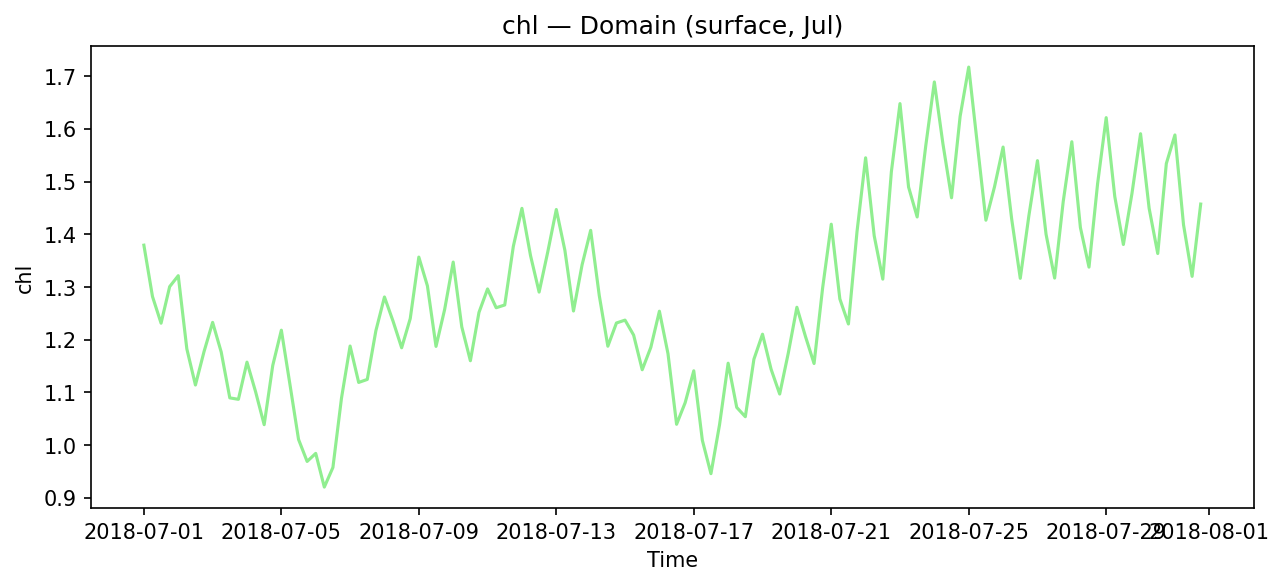

• timeseries/output_updated_river_var__Station-WE12__multi__surface__AllTime__Timeseries__CombinedByVar.png


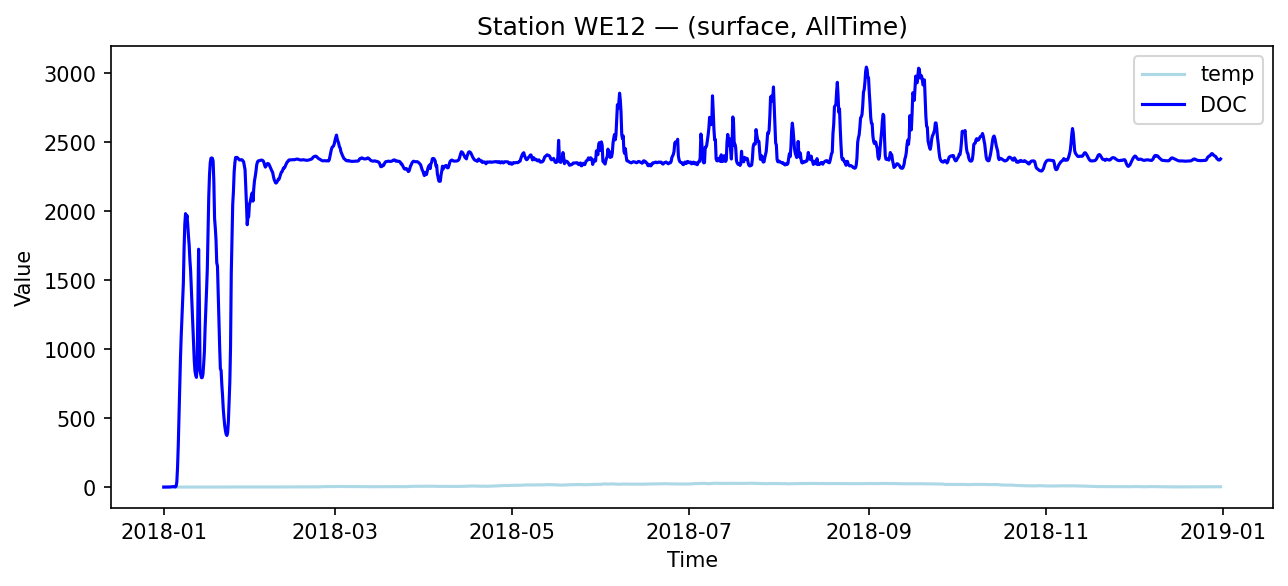

• timeseries/output_updated_river_var__Region-All__DOC__bottom__AllTime__Timeseries__CombinedByRegion.png


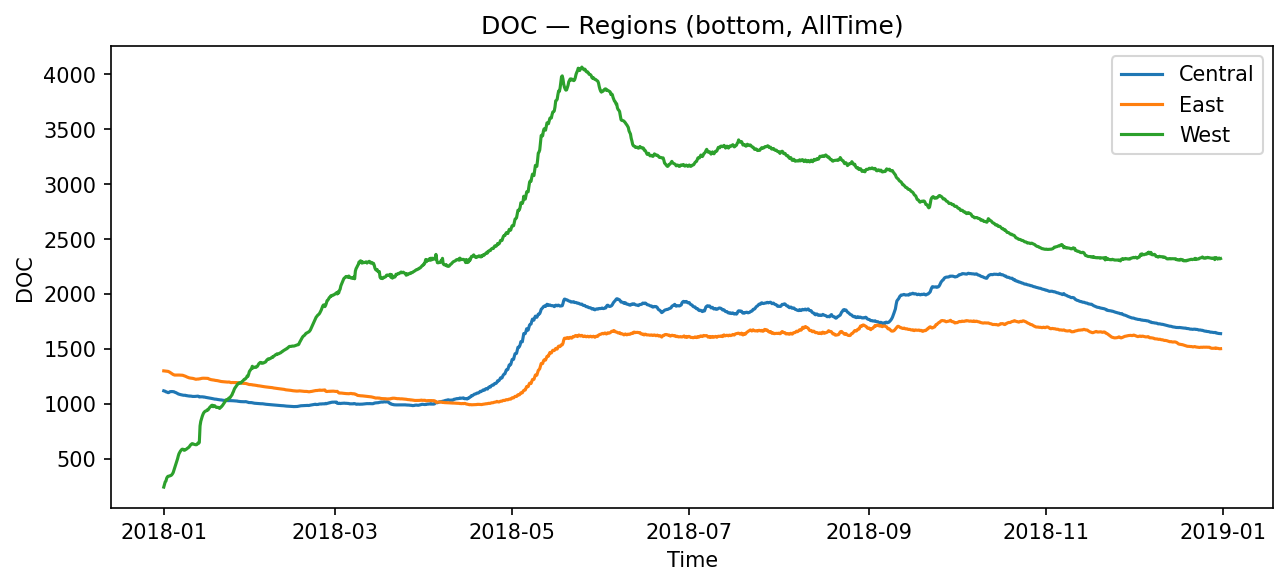

• timeseries/output_updated_river_var__Domain__DOC__3Panel__AllTime__Timeseries.png


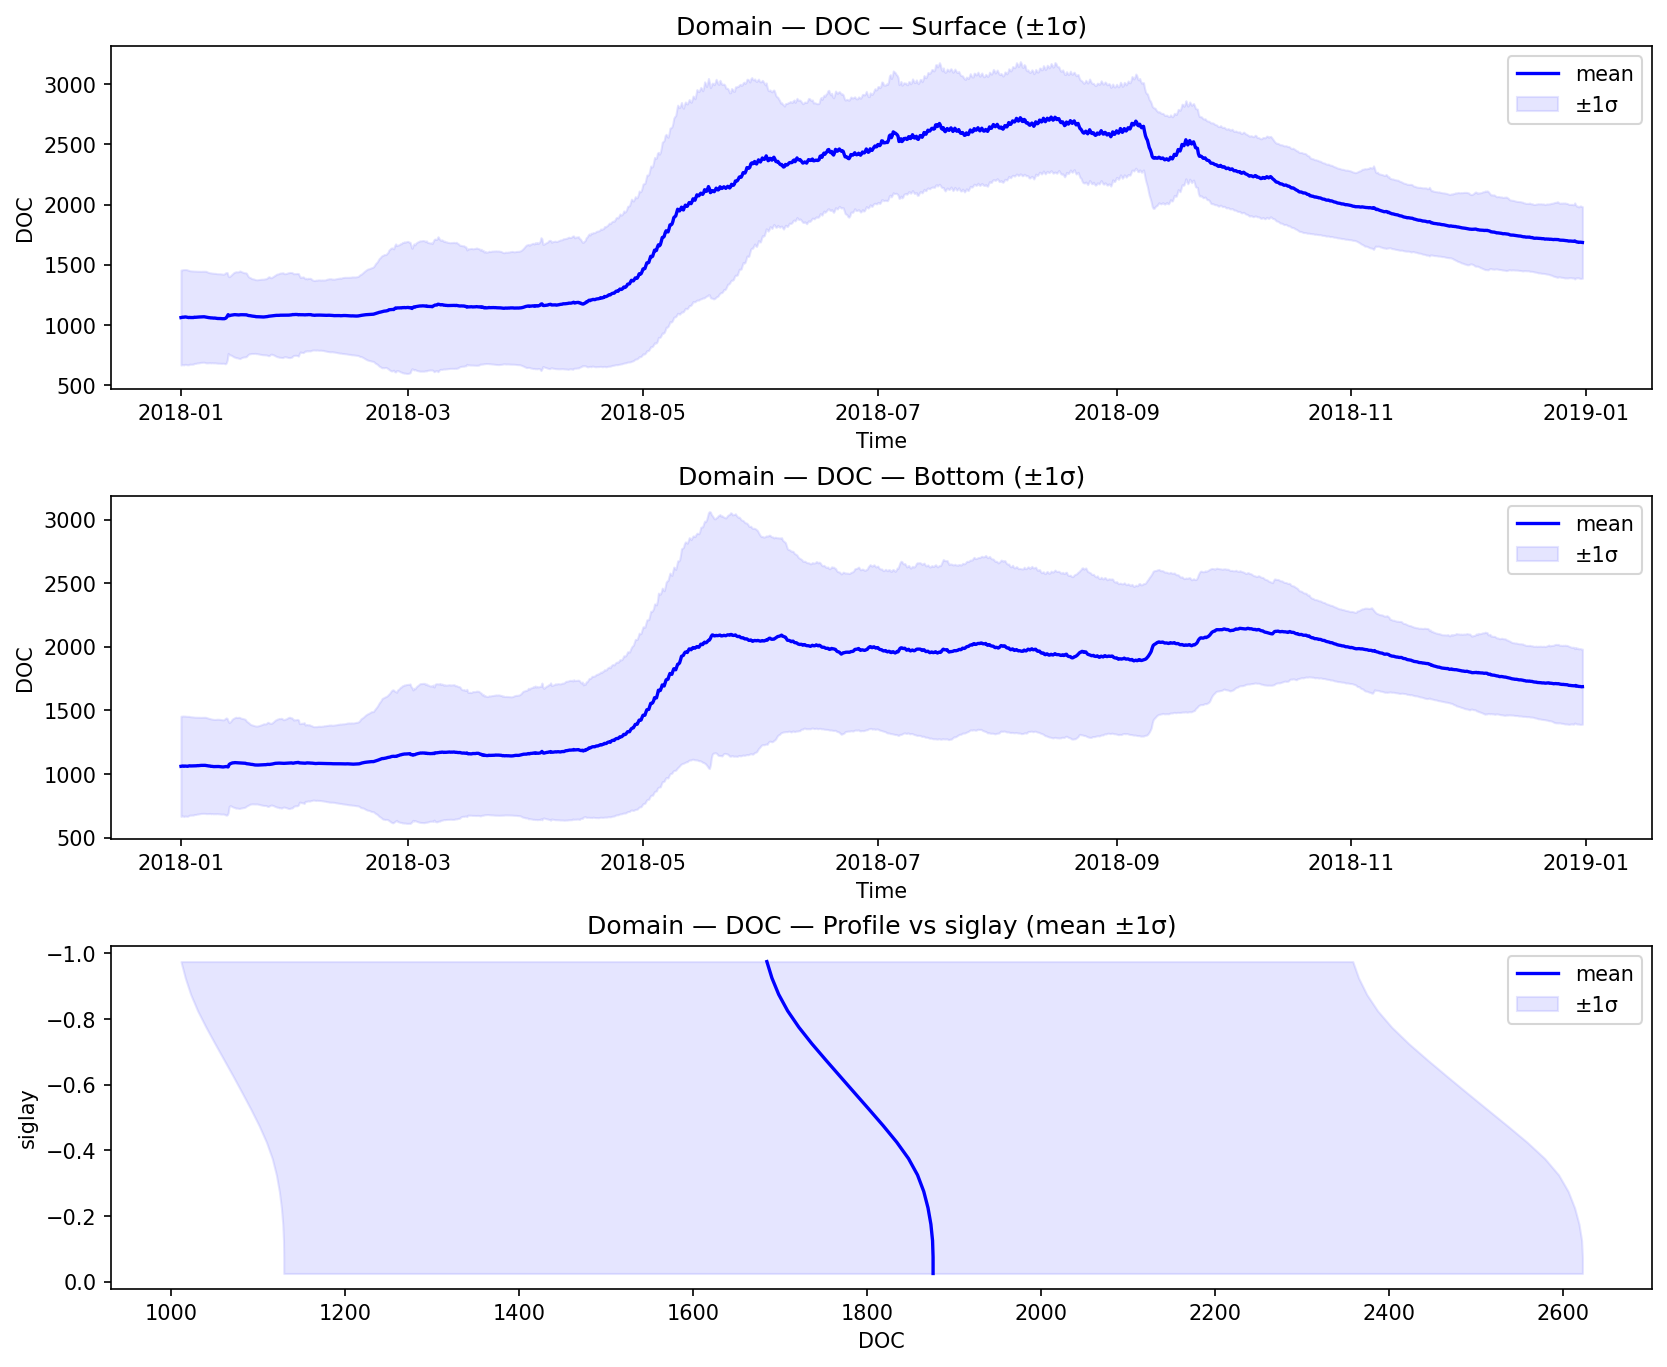

• timeseries/output_updated_river_var__Station-WE12__chl__3Panel__AllTime__Timeseries.png


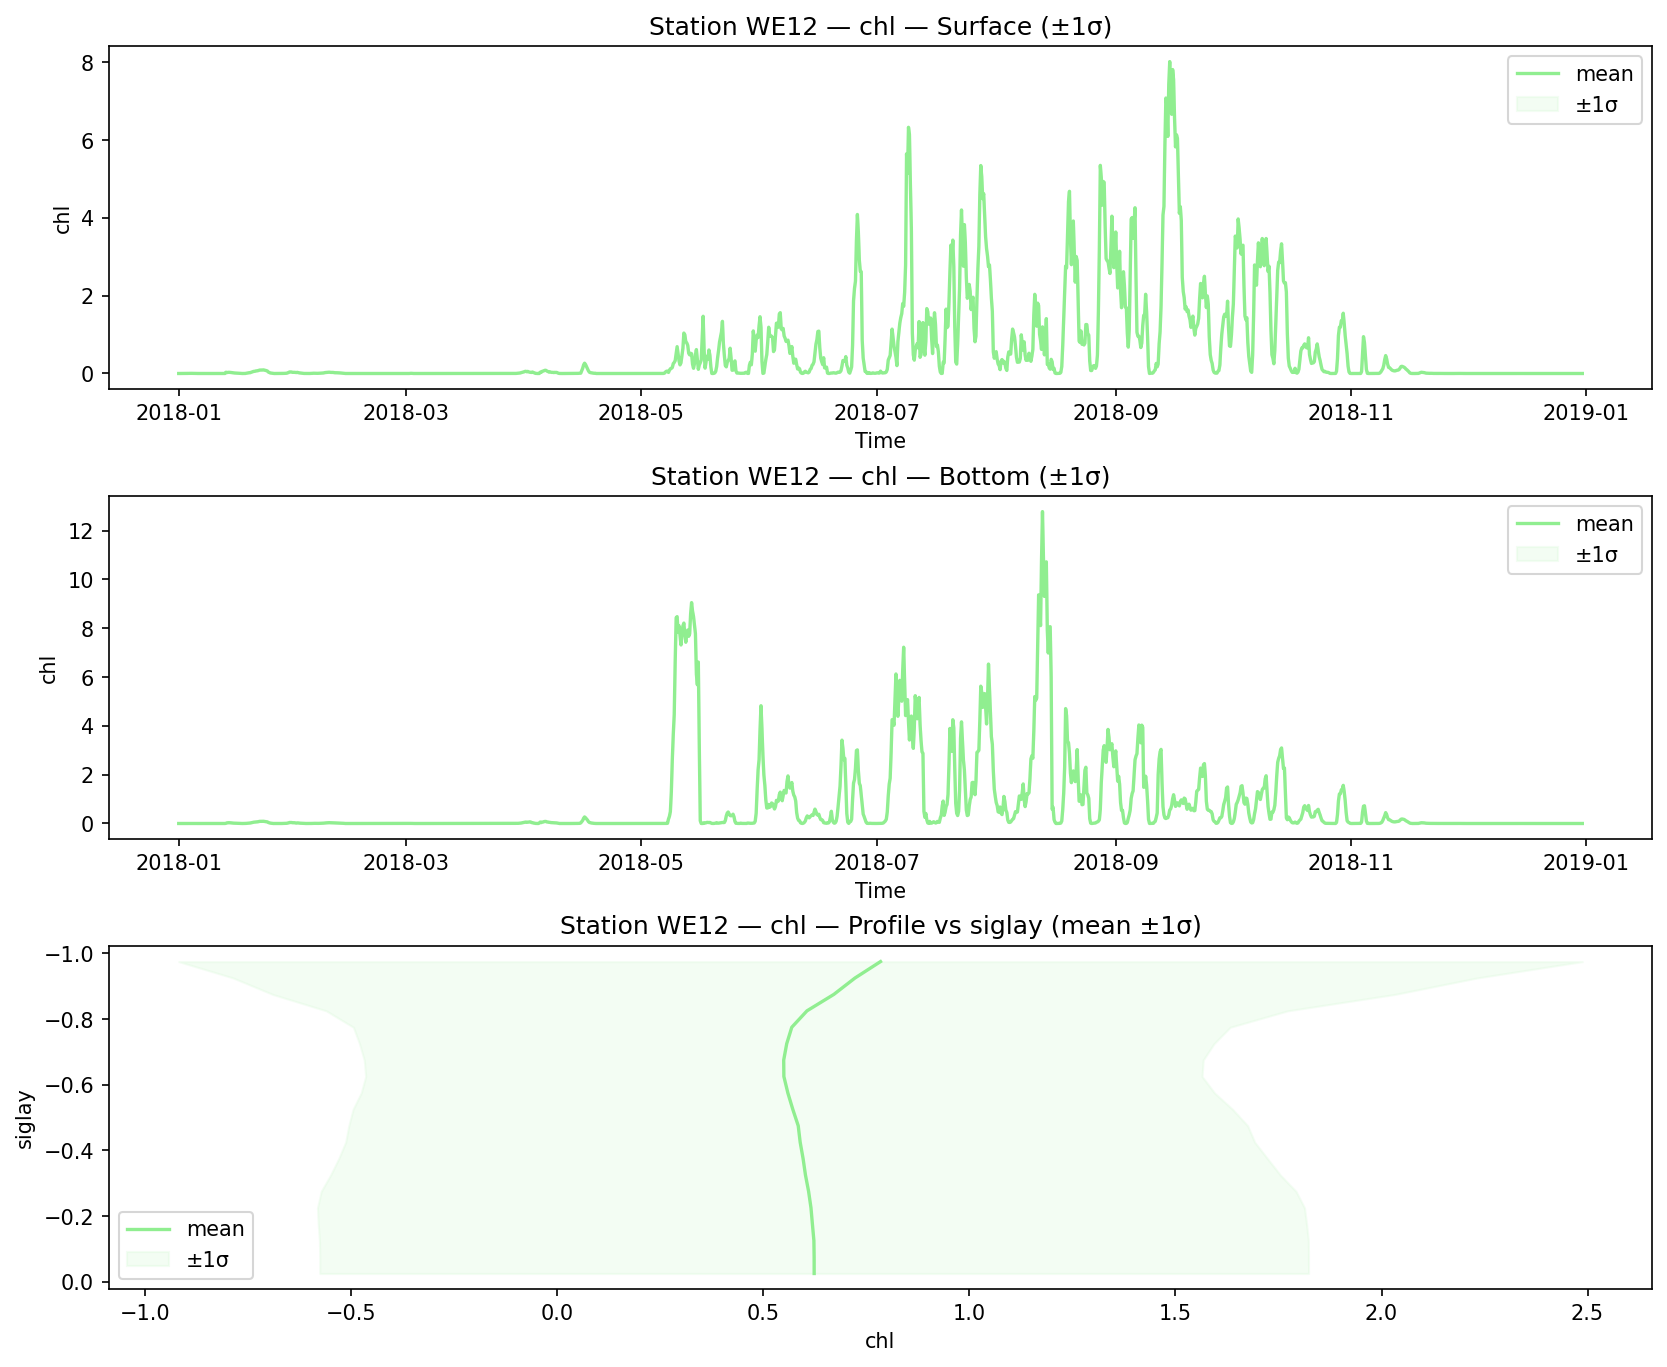

• timeseries/output_updated_river_var__Region-Central__temp__3Panel__AllTime__Timeseries.png


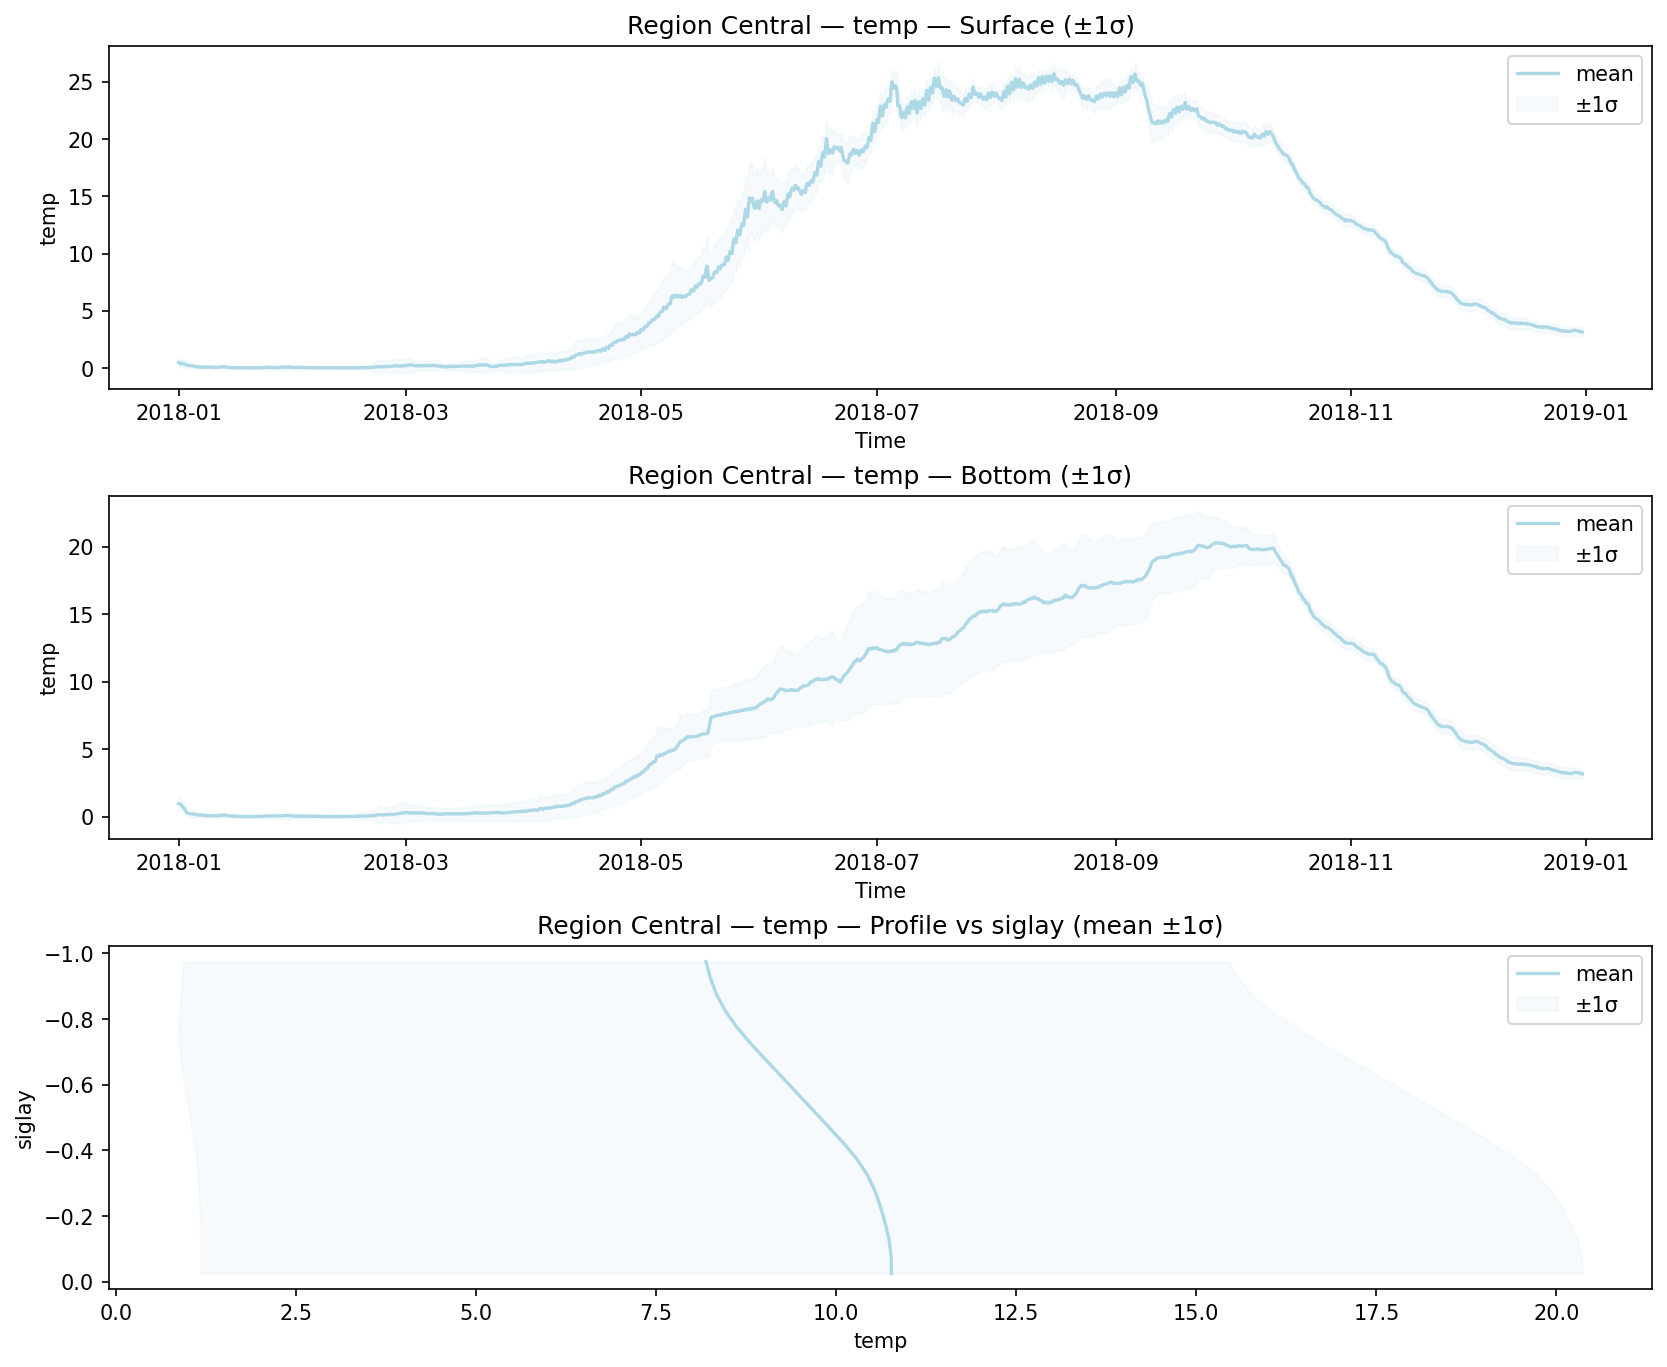

In [5]:
# --- Timeseries examples: domain, station, region  ---
from fvcomersemviz.plots.timeseries import (
    domain_mean_timeseries,
    station_timeseries,
    region_timeseries,
    domain_three_panel,
    station_three_panel,
    region_three_panel,
)

# 1) Domain mean — single var
domain_mean_timeseries(
    ds=ds, variables=["chl"],
    depth="surface",
    months=[7],
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    groups=GROUPS, styles=PLOT_STYLES, verbose=False
)

# 2) Station — multi-var, one plot
station_timeseries(
    ds=ds, variables=["temp", "DOC"],
    stations=[STATIONS[0]],
    depth="surface",
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    groups=GROUPS, styles=PLOT_STYLES,
    combine_by="var", verbose=False
)

# 3) Region — compare regions, one var
region_timeseries(
    ds=ds, variables=["DOC"],
    regions=REGIONS,
    depth="bottom",
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    groups=GROUPS, styles=PLOT_STYLES,
    combine_by="region", verbose=False
)

# 4) Domain three-panel (Surface ±1σ, Bottom ±1σ, Depth-avg ±1σ)
domain_three_panel(
    ds=ds, variables=["DOC"],
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    groups=GROUPS, styles=PLOT_STYLES, verbose=False
)

# 5) Station three-panel
station_three_panel(
    ds=ds, variables=["chl"],
    stations=[STATIONS[0]],
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    groups=GROUPS, styles=PLOT_STYLES, verbose=False
)

# 6) Region three-panel
region_three_panel(
    ds=ds, variables=["temp"],
    regions=[REGIONS[0]],
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    groups=GROUPS, styles=PLOT_STYLES, verbose=False
)


print(" Timeseries examples completed. Figures saved under:", FIG_DIR)



# Build the output root from your existing config
RUN_ROOT = Path(FIG_DIR) / Path(BASE_DIR).name     # e.g. <FIG_DIR>/<basename(BASE_DIR)>
OUT_ROOT = RUN_ROOT / "timeseries"                 

print("Looking under:", OUT_ROOT.resolve())

if not OUT_ROOT.exists():
    print(f" Folder does not exist: {OUT_ROOT}")
else:
    # grab newest first; include PNG and SVG
    files = sorted(
        list(OUT_ROOT.rglob("*.png")) + list(OUT_ROOT.rglob("*.svg")),
        key=lambda p: p.stat().st_mtime
    )
    if not files:
        print(f"No images found under {OUT_ROOT}")
    else:
        N = 20  # how many to show
        print(f"Found {len(files)} image(s). Showing the latest {min(N, len(files))}…")
        for p in files[-N:]:
            print("•", p.relative_to(RUN_ROOT))
            if p.suffix.lower() == ".svg":
                display(SVG(filename=str(p)))
            else:
                display(Image(filename=str(p)))


## Maps examples

a detailed overviww of the map plotting functions and more examples can be found in notebooks/plot_maps.ipynb

 Map examples completed. Figures saved under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/
Looking under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/output_updated_river_var/maps
Found 2 image(s). Showing the latest 2…
• maps/output_updated_river_var__Map-Domain__chl__surface__2018-07-15T0000__Instant.png


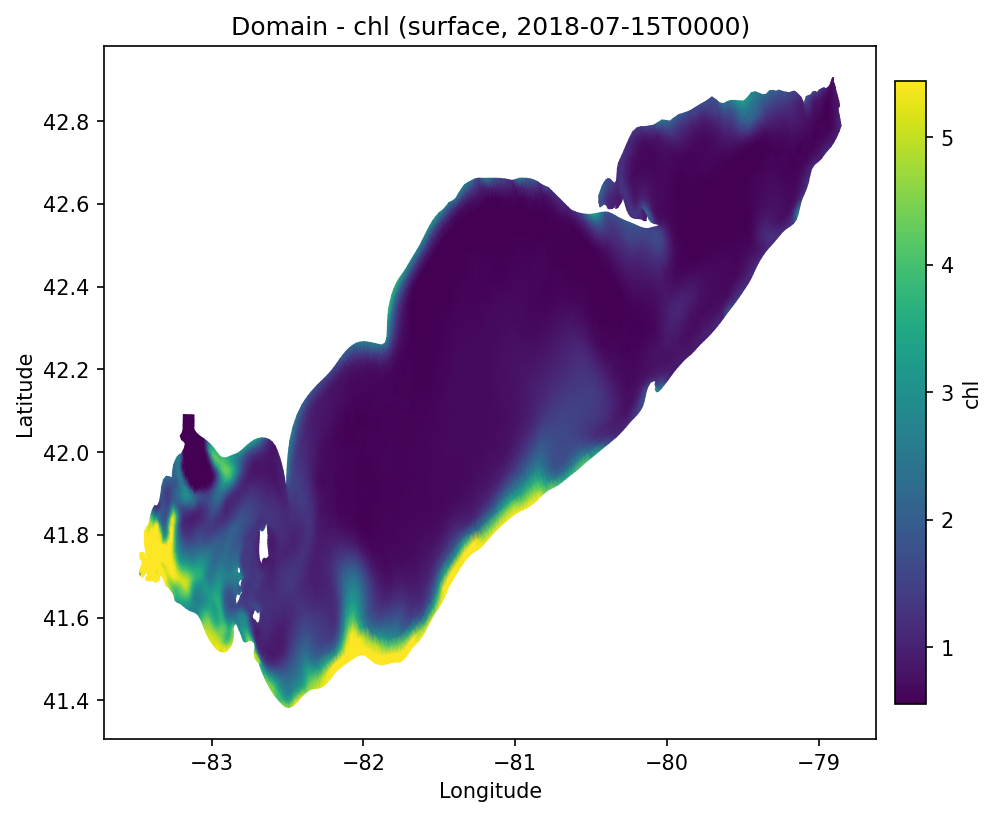

• maps/output_updated_river_var__Map-Region-Central__chl__surface__Jul__2018__Mean.png


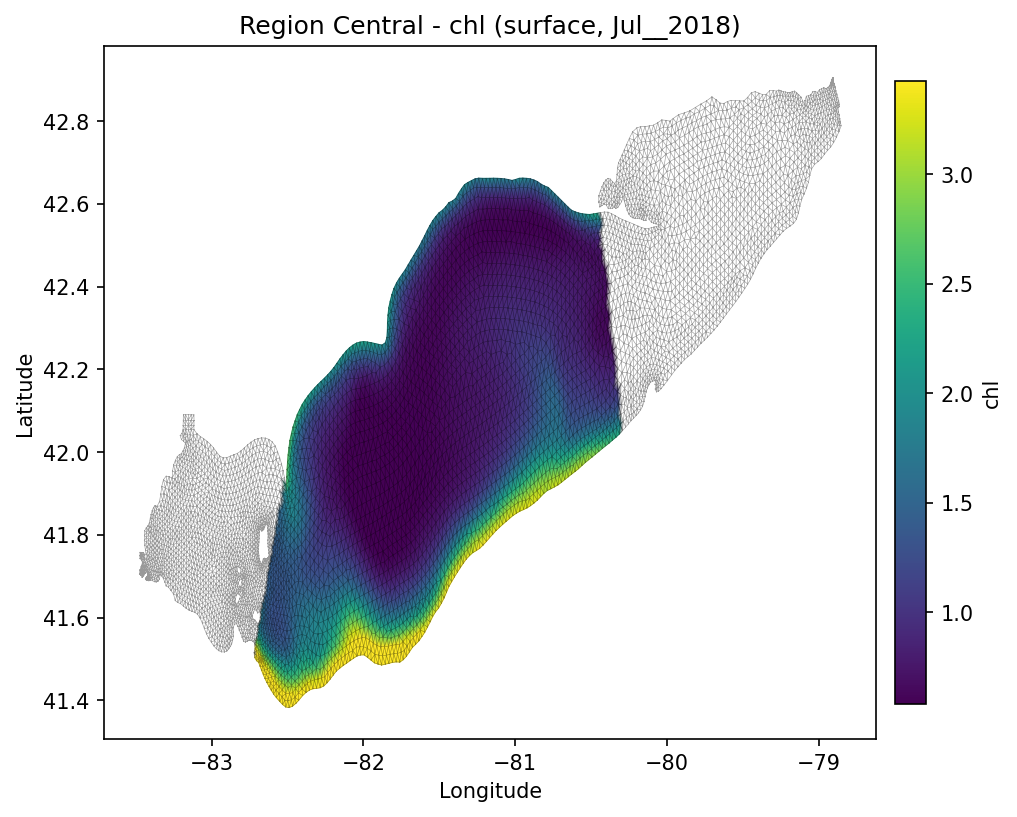

In [6]:
# --- Map examples: domain + region  ---



from fvcomersemviz.plots.maps import domain_map, region_map

# 7) Domain map — single instant
domain_map(
    ds=ds, variables=["chl"],
    depth="surface",
    at_time="2018-07-15",
    base_dir=BASE_DIR, 
    figures_root=FIG_DIR,
    groups=GROUPS, 
    grid_on=False,
    verbose=False
)

# 8) Region map — time mean over a window
region_map(
    ds=ds, variables=["chl"],
    regions=[REGIONS[0]],
    depth="surface",
    months=[7], years=[2018],
    base_dir=BASE_DIR, 
    figures_root=FIG_DIR,
    grid_on=True,
    groups=GROUPS, verbose=False
)

print(" Map examples completed. Figures saved under:", FIG_DIR)

# View figures in the notebook
# Build the output root from your existing config
RUN_ROOT = Path(FIG_DIR) / Path(BASE_DIR).name     # e.g. <FIG_DIR>/<basename(BASE_DIR)>
OUT_ROOT = RUN_ROOT / "maps"     

print("Looking under:", OUT_ROOT.resolve())

if not OUT_ROOT.exists():
    print(f" Folder does not exist: {OUT_ROOT}")
else:
    # grab newest first; include PNG and SVG
    files = sorted(
        list(OUT_ROOT.rglob("*.png")) + list(OUT_ROOT.rglob("*.svg")),
        key=lambda p: p.stat().st_mtime
    )
    if not files:
        print(f"No images found under {OUT_ROOT}")
    else:
        N = 12  # how many to show
        print(f"Found {len(files)} image(s). Showing the latest {min(N, len(files))}…")
        for p in files[-N:]:
            print("•", p.relative_to(RUN_ROOT))
            if p.suffix.lower() == ".svg":
                display(SVG(filename=str(p)))
            else:
                display(Image(filename=str(p)))

## Hovmoller example
a detailed overviww of the hovmoller plotting functions and more examples can be found in notebooks/plot_hovmoller.ipynb

[hovmoller:WE12] DOC (z)
[io] Added node vertical coord 'z' with dims ('time', 'siglay', 'node')
[io] Added element vertical coord 'z_nele' with dims ('time', 'siglay', 'nele')
[hovmoller:WE12] saved output_updated_river_var__Hovmoller-Station-WE12__DOC__z__Apr-Oct__2018.png
 Hovmöller examples completed. Figures saved under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/
Showing the latest 1 Hovmöller plot(s) from /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/output_updated_river_var/hovmoller:
• hovmoller/output_updated_river_var__Hovmoller-Station-WE12__DOC__z__Apr-Oct__2018.png


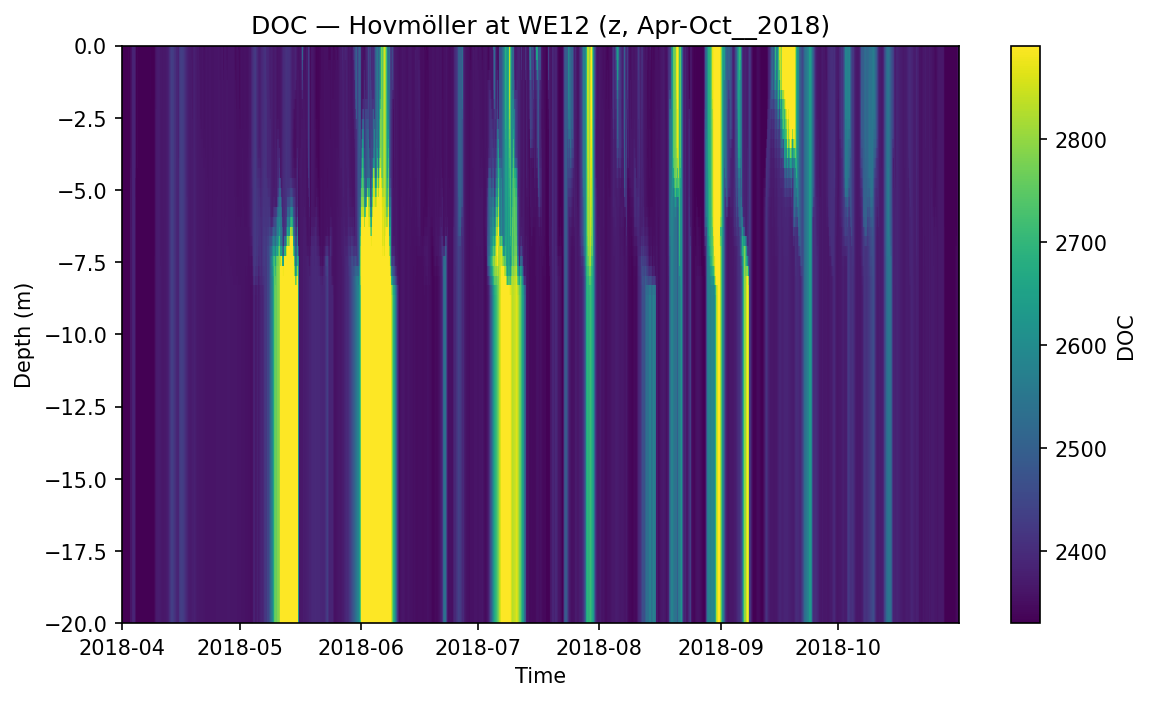

In [7]:
# --- Hovmöller examples: station time × depth (save + inline preview) ---

from fvcomersemviz.plots.hovmoller import station_hovmoller


# 9) WE12 — DOC on absolute depth z (Apr–Oct 2018), explicit z grid
station_hovmoller(
    ds=ds,
    variables=["DOC"],
    stations=[STATIONS[0]],
    axis="z",
    z_levels=np.linspace(-20.0, 0.0, 60), # omit to auto-build from column depth
    months= [4, 5, 6, 7, 8, 9, 10],   # Apr–Oct
    years  = [2018],
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    groups=GROUPS,
    styles=PLOT_STYLES,
)


print(" Hovmöller examples completed. Figures saved under:", FIG_DIR)

# ---- Inline preview: -------
RUN_ROOT = Path(FIG_DIR) / Path(BASE_DIR).name        
HOV_DIR  = RUN_ROOT / "hovmoller"                      
search_root = HOV_DIR if HOV_DIR.exists() else RUN_ROOT

files = sorted(
    list(search_root.rglob("*.png")) + list(search_root.rglob("*.svg")),
    key=lambda p: p.stat().st_mtime
)

if not files:
    print(f"No Hovmöller images found under {search_root}")
else:
    N = 12
    print(f"Showing the latest {min(N, len(files))} Hovmöller plot(s) from {search_root}:")
    for p in files[-N:]:
        print("•", p.relative_to(RUN_ROOT))
        if p.suffix.lower() == ".svg":
            display(SVG(filename=str(p)))
        else:
            display(Image(filename=str(p)))


## Community composition examples
a detailed overviww of the composition plotting functions and more examples can be found in notebooks/plot_composition.ipynb

In [ ]:
## fill in composition examples here

## Stoichiometry KDE (2×2) examples
a detailed overviww of the stoichiometry plotting functions and more examples can be found in notebooks/plot_kde.ipynb

 KDE stoichiometry examples completed. Figures saved under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/
Showing the latest 3 KDE plot(s) from /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/output_updated_river_var/kde_stoichiometry:
• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__chl__Domain__AllTime.png


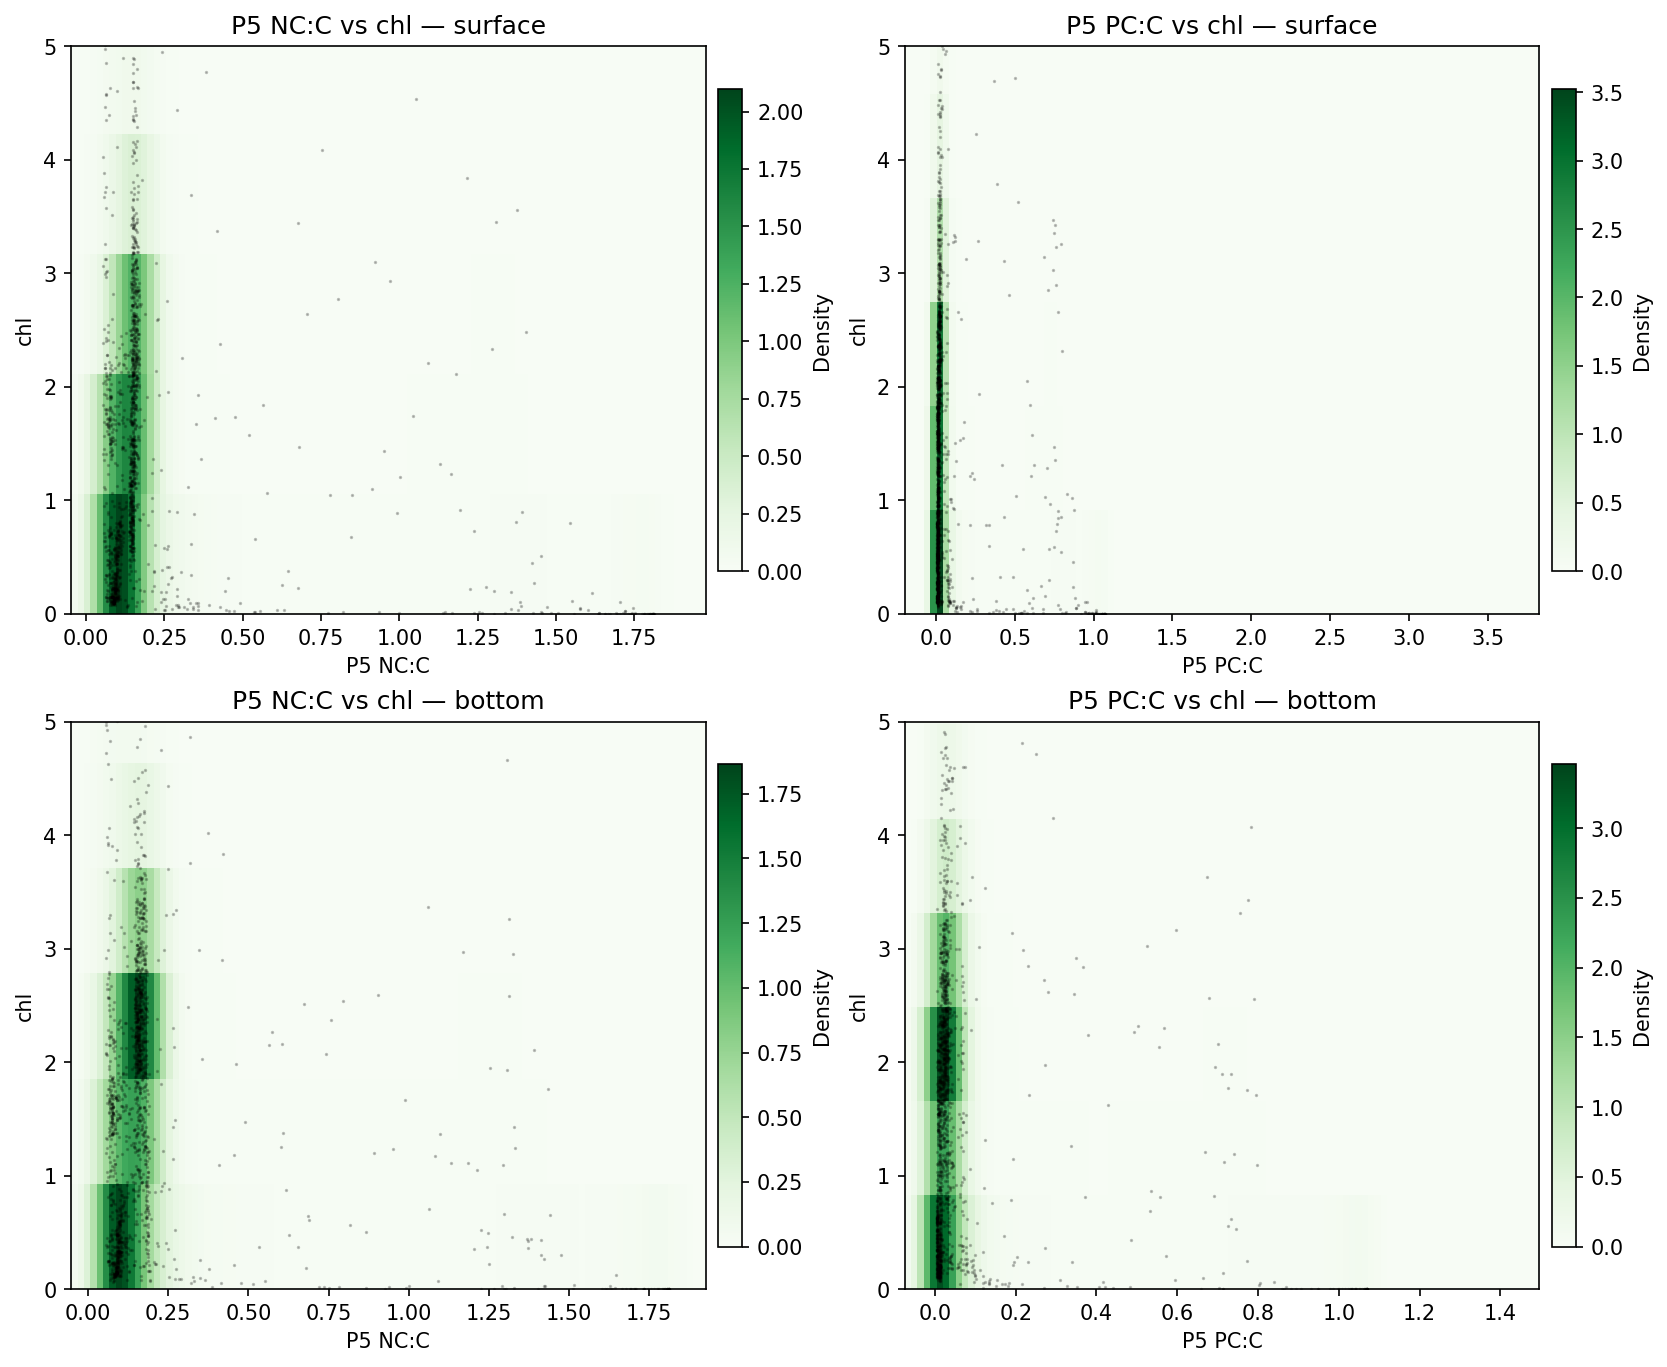

• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__P5_c__Central__Jun-Aug__2018.png


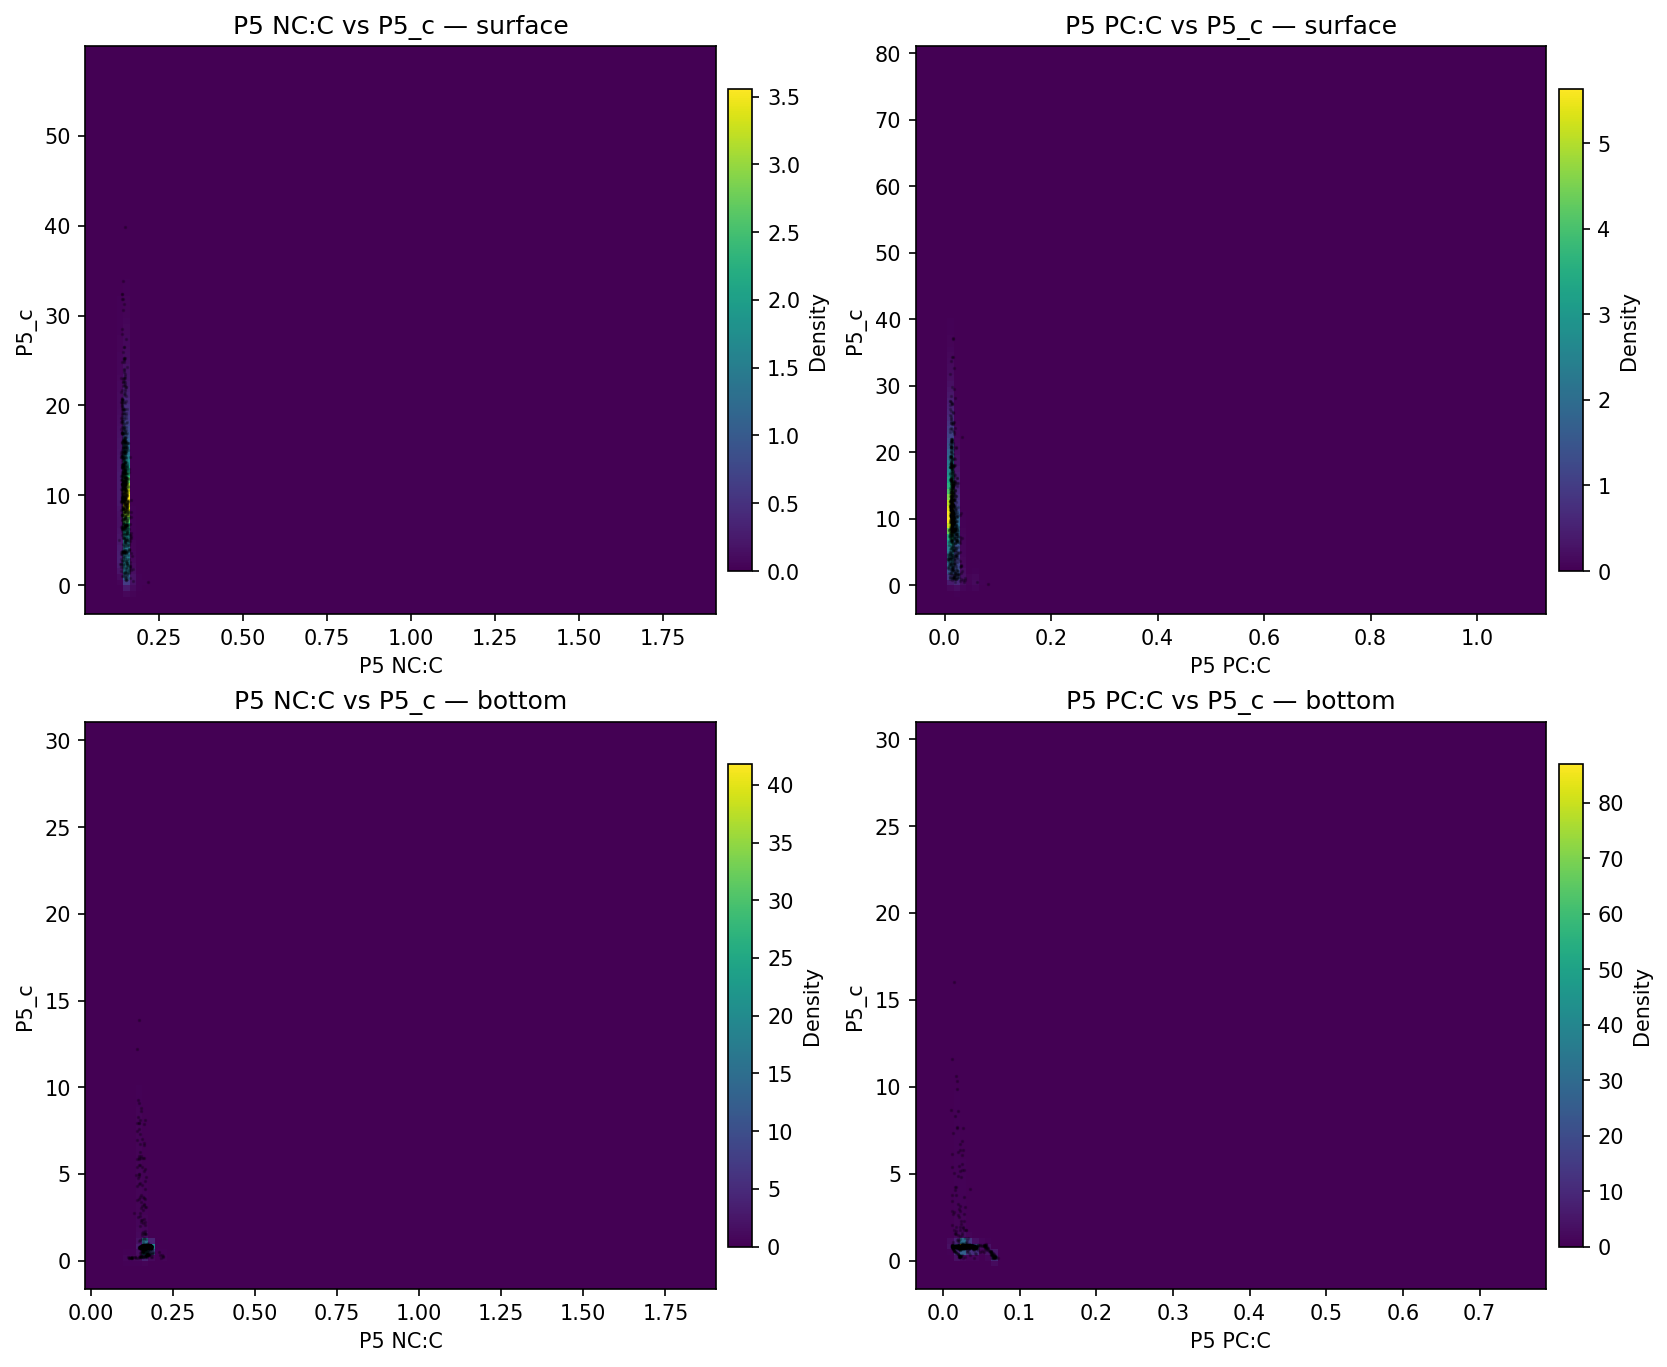

• kde_stoichiometry/output_updated_river_var__KDE-Stoich__P5__P5_c__East__Jun-Aug__2018.png


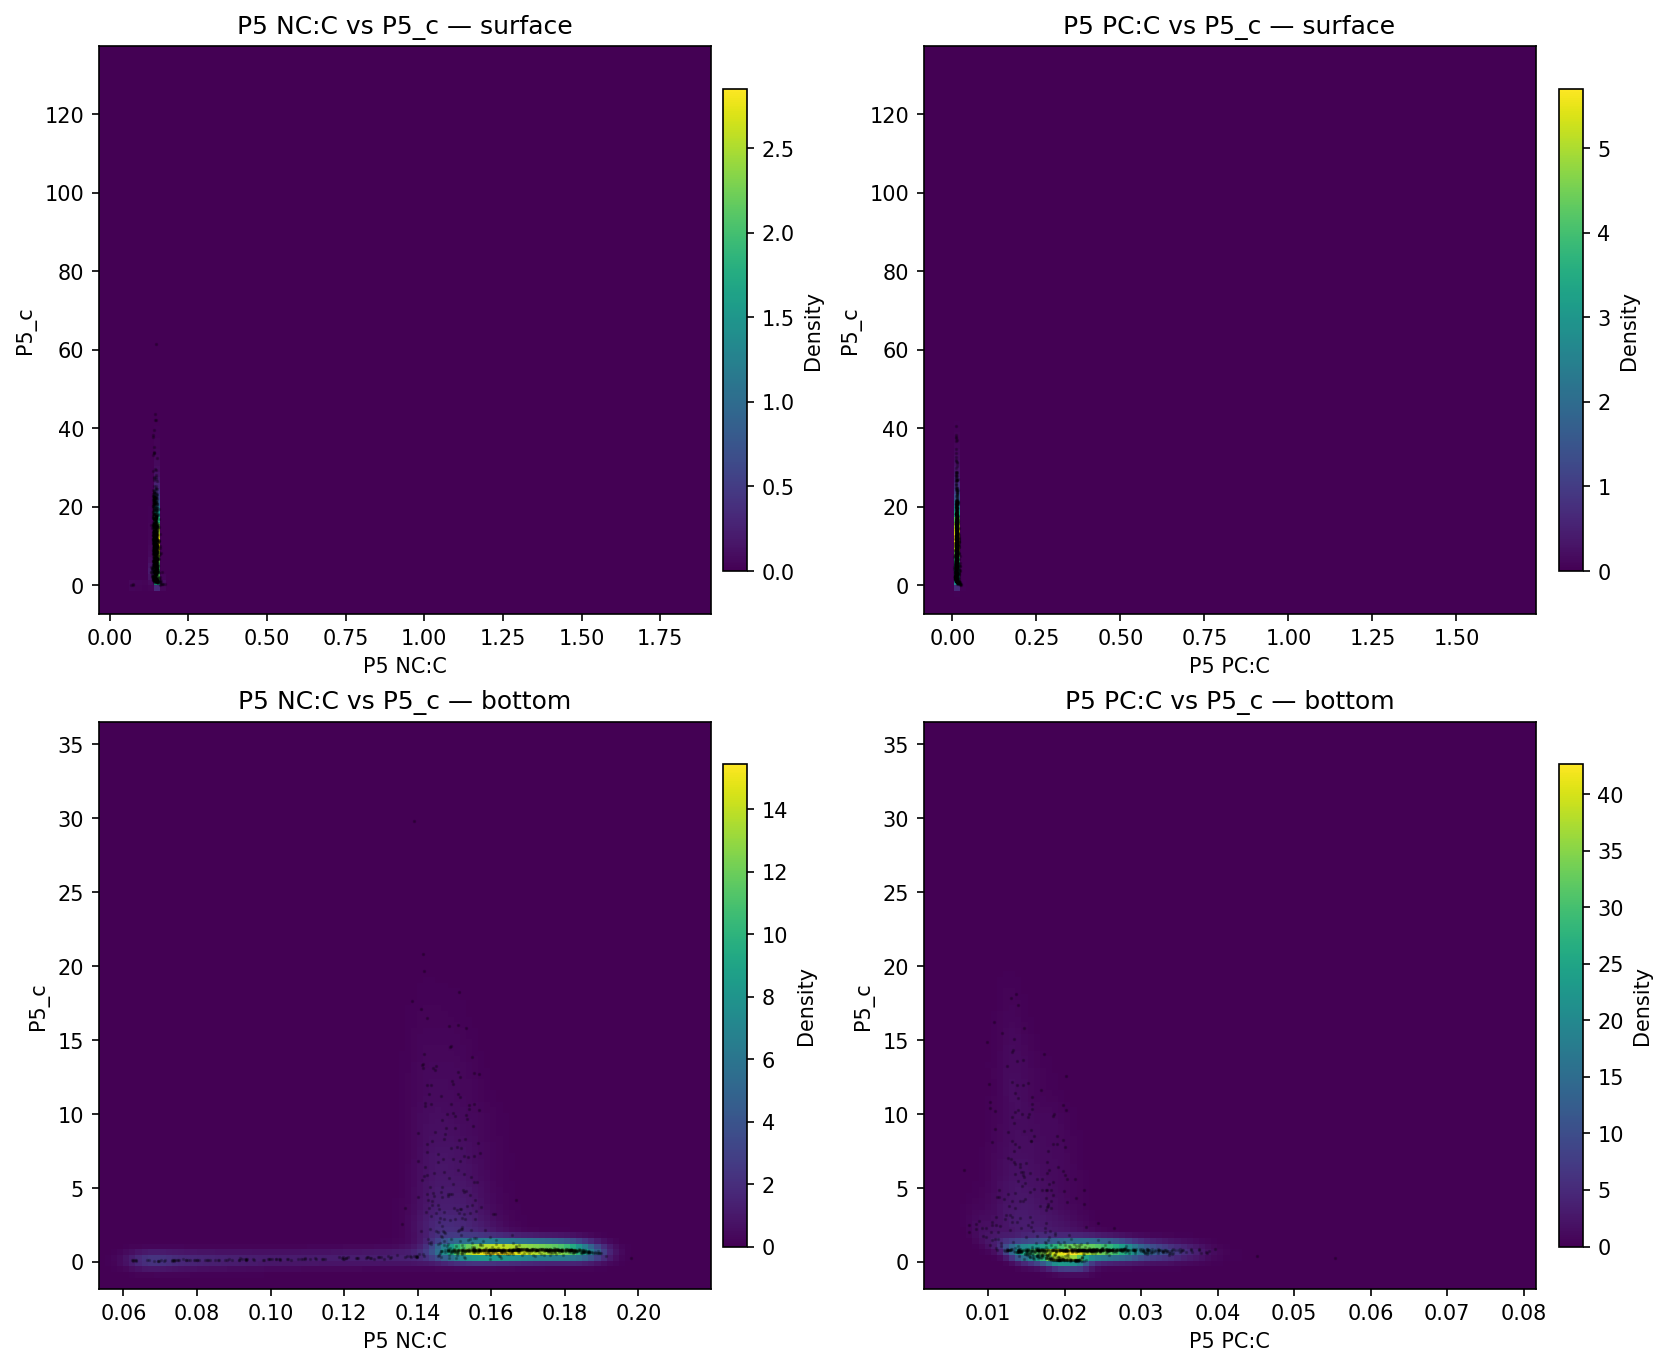

In [8]:
# --- Stoichiometry KDE (2×2) examples:  ---

from fvcomersemviz.plots.kde_stoichiometry import kde_stoichiometry_2x2

# Fast/default options
FAST = dict(
    method="kde",          # "kde" (accurate) or "hist" (very fast on huge datasets)
    sample_max=150_000,    # cap pooled pairs for speed
    hist_sigma=1.2,        # blur (bins) if method="hist"
    grids=100,             # density grid resolution
    bw_method="scott",     # KDE bandwidth (ignored if method="hist")
    verbose=False,
)


# 10) DOMAIN • full run • group=P5 • variable=chl (composite)
kde_stoichiometry_2x2(
    ds=ds,
    group="P5",
    variable="chl",
    region=None,
    months=None, years=None,         # full time span
    base_dir=BASE_DIR, figures_root=FIG_DIR, groups=GROUPS,
    min_samples=300, scatter_underlay=1500,
    styles=PLOT_STYLES if "PLOT_STYLES" in globals() else None,
    **FAST,
)

# 11) REGION COMPARISON • JJA 2018 • group=P5 • variable=P5_c (first two regions if available)
if "REGIONS" in globals() and len(REGIONS) >= 2:
    for reg in REGIONS[:2]:
        kde_stoichiometry_2x2(
            ds=ds,
            group="P5",
            variable="P5_c",
            region=reg,
            months=[6,7,8], years=[2018],
            base_dir=BASE_DIR, figures_root=FIG_DIR, groups=GROUPS,
            min_samples=180, scatter_underlay=800,
            styles=PLOT_STYLES if "PLOT_STYLES" in globals() else None,
            **FAST,
        )

print(" KDE stoichiometry examples completed. Figures saved under:", FIG_DIR)

# ---- Inline preview: show newest KDE images from this run ----
RUN_ROOT = Path(FIG_DIR) / Path(BASE_DIR).name                 # <FIG_DIR>/<basename(BASE_DIR)>
KDE_DIR  = RUN_ROOT / "kde_stoichiometry"                      # default subfolder (fallback to RUN_ROOT if absent)
search_root = KDE_DIR if KDE_DIR.exists() else RUN_ROOT

files = sorted(
    list(search_root.rglob("*.png")) + list(search_root.rglob("*.svg")),
    key=lambda p: p.stat().st_mtime
)

if not files:
    print(f"No KDE images found under {search_root}")
else:
    N = 8
    print(f"Showing the latest {min(N, len(files))} KDE plot(s) from {search_root}:")
    for p in files[-N:]:
        print("•", p.relative_to(RUN_ROOT))
        if p.suffix.lower() == ".svg":
            display(SVG(filename=str(p)))
        else:
            display(Image(filename=str(p)))

## Curves examples
a detailed overviww of the curve plotting functions and more examples can be found in notebooks/plot_curves.ipynb

 Curve examples completed. Figures saved under: /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/
Showing the latest 1 curve plot(s) from /data/proteus1/scratch/moja/projects/Lake_Erie/fviz-plots/tutorial/output_updated_river_var/curves:
• curves/output_updated_river_var__Curves__Domain__zavg__Apr-Oct__2018__temp_vs_phyto_c_total.png


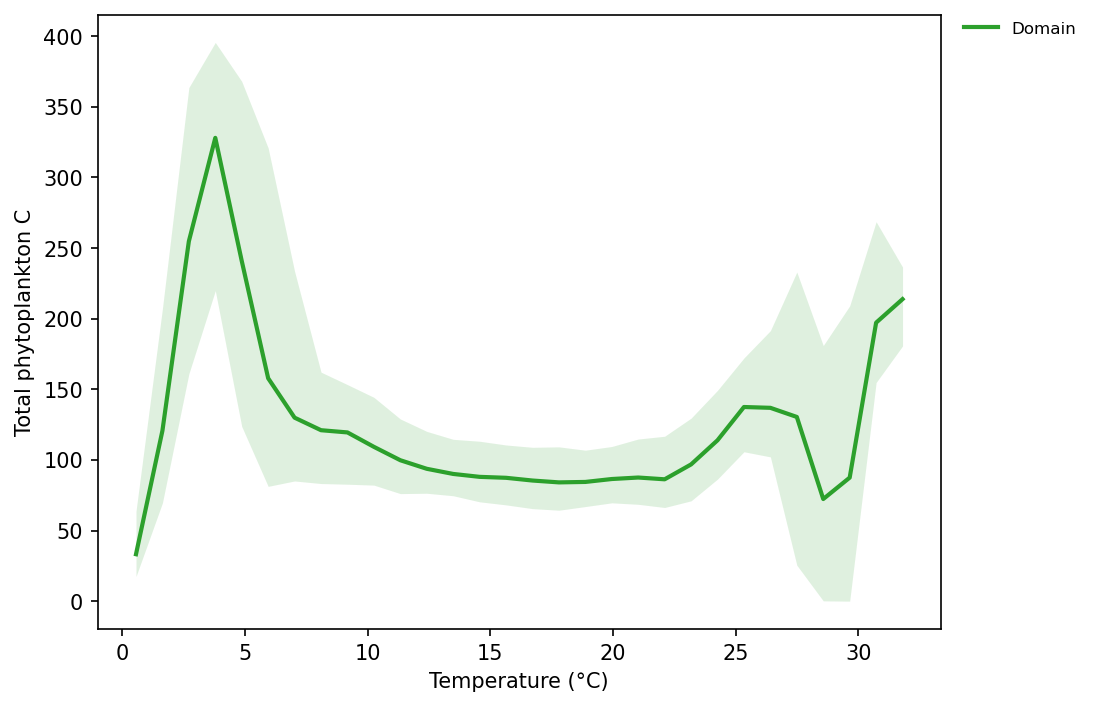

In [9]:
# --- Curves (x–y) ---


from fvcomersemviz.plots.curves import plot_curves

# We use different groups / variables for this example - so we will need to update the GROUPS dictionary
GROUPS = {
    "phyto_c_total": "P1_c  + P2_c  + P4_c  + P5_c",
}


# 12) Total phyto C vs. Temp Apr-Oct, Full domain 
# Example spec
specs_temp_phyto = [{
    "name": "Domain",
    "x": "temp",
    "y": "phyto_c_total",
    "filters": {"months": [4,5,6,7,8,9,10], "years": [2018]},
    "depth": "depth_avg",
    "scope": {},  # domain
    "bin": {"x_bins": 32, "agg": "median", "min_count": 20, "iqr": True},
    "style": {"color": "C2"},
    "x_label": "Temperature (°C)",
    "y_label": "Total phytoplankton C",
}]

# Plot
plot_curves(
    specs=specs_temp_phyto, ds=ds, groups=GROUPS,
    base_dir=BASE_DIR, figures_root=FIG_DIR, dpi=150,
)


print(" Curve examples completed. Figures saved under:", FIG_DIR)

# ---- Inline preview: show curves images from this run ----
RUN_ROOT = Path(FIG_DIR) / Path(BASE_DIR).name                 # <FIG_DIR>/<basename(BASE_DIR)>
CURVES_DIR  = RUN_ROOT / "curves"                    
search_root = CURVES_DIR if CURVES_DIR.exists() else RUN_ROOT

files = sorted(
    list(search_root.rglob("*.png")) + list(search_root.rglob("*.svg")),
    key=lambda p: p.stat().st_mtime
)

if not files:
    print(f"No curve images found under {search_root}")
else:
    N = 8
    print(f"Showing the latest {min(N, len(files))} curve plot(s) from {search_root}:")
    for p in files[-N:]:
        print("•", p.relative_to(RUN_ROOT))
        if p.suffix.lower() == ".svg":
            display(SVG(filename=str(p)))
        else:
            display(Image(filename=str(p)))

## Animations examples
a detailed overviww of the animation functions and more examples can be found in notebooks/plot_animations.ipynb




In [ ]:


# Reset our groups and our plot styles

GROUPS = {
    "DOC":   "R1_c + R2_c + R3_c + T1_30d_c + T2_30d_c",  # dissolved organic carbon (sum of pools)
    "phyto": ["P1_c", "P2_c", "P4_c", "P5_c"],            # total phytoplankton carbon (sum)
    "zoo":   ["Z4_c", "Z5_c", "Z6_c"],                    # total zooplankton carbon (sum)
    "chl":   "P1_Chl + P2_Chl + P4_Chl + P5_Chl",         # total chlorophyll (sum)
}

PLOT_STYLES = {
    "temp":   {"line_color": "lightblue", "cmap": "coolwarm"},
    "DOC":   {"line_color": "blue", "cmap": "viridis"},
    "chl":   {"line_color": "lightgreen", "cmap": "Greens", "vmin": 0.0, "vmax": 5.0},
    "phyto": {"line_color": "darkgreen","cmap": "YlGn"},
    "zoo":   {"line_color": "purple","cmap": "PuBu"},
}


In [ ]:



from fvcomersemviz.plots.animate import animate_timeseries

# 13) REGIONS — combine_by='var': one GIF per region, lines = variables

info("[animate] Regions (per region, lines = vars)…")
anim = animate_timeseries(
    ds,
    vars=["chl", "phyto", "zoo"],
    groups=GROUPS,
    scope="region",
    regions=REGIONS,
    months=[6, 7, 8], years=2018,
    depth={"z_m": -10},          # 10 m below surface
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    combine_by="var",            # one animation per region; lines are variables
    styles=PLOT_STYLES,
    verbose=False,
)


# 14) REGIONS — combine_by='region': one GIF per variable, lines = regions

info("[animate] Regions (per var, lines = regions)…")
anim = animate_timeseries(
    ds,
    vars=["chl", "phyto"],
    groups=GROUPS,
    scope="region",
    regions=REGIONS,
    years=2018,
    depth="surface",
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    combine_by="region",         # one animation per variable; lines are regions
    styles=PLOT_STYLES,
    verbose=False,
)

print(" Timeseries animation examples completed. Animations saved under:", FIG_DIR)

RUN_ROOT = Path(FIG_DIR) / Path(BASE_DIR).name          # <FIG_DIR>/<basename(BASE_DIR)>
ANIM_DIR = RUN_ROOT / "animate"                      # flat folder with animations

search_root = ANIM_DIR if ANIM_DIR.exists() else RUN_ROOT

# Non-recursive listing; only .gif and .mp4
anims = sorted(
    [p for p in search_root.iterdir() if p.suffix.lower() in {".gif", ".mp4"}],
    key=lambda p: p.stat().st_mtime
)

if not anims:
    print(f"No GIF/MP4 animations found under {search_root}")
else:
    print(f"Found {len(anims)} animation(s) under {search_root}\n")
    for p in anims:
        display(HTML(f"<div style='font-family:monospace; margin:0.25em 0;'>• {p.relative_to(RUN_ROOT)}</div>"))
        if p.suffix.lower() == ".gif":
            display(Image(filename=str(p), width=720))
        else:  # .mp4
            display(Video(filename=str(p), embed=True, width=720))


In [ ]:
## Animate Maps

from fvcomersemviz.plots.animate import animate_maps

# 15) DOMAIN MAPS - daily frames for June 2018 at the surface
#    Uses robust color limits per time window unless overridden by MAP_STYLES or clim/norm.
print("[animate] domain map animation (daily, surface, June 2018)")
animate_maps(
    ds,
    variables=["temp", "chl"],   # native variables or GROUPS keys both work
    scope="domain",
    months=6, years=2018,
    depth="surface",
    groups=GROUPS,
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    frequency="daily",          #  hourly | daily | monthly
    grid_on=True,                # draw mesh overlay
    styles=PLOT_STYLES,           # optional per-var map styling
    verbose=True,
)

# 16) REGION MAPS  all avaiable frames across JJA 2018 at 10 m below surface
print("[animate] region map animation (daily, z=10 m below surface, JJA 2018)")
animate_maps(
    ds,
    variables=["chl"],
    scope="region",
    regions=REGIONS,
    months=[6, 7, 8], years=2018,
    depth={"z_m": -10},          # absolute metres below surface (negative down)
    groups=GROUPS,
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    grid_on=False,
    styles=PLOT_STYLES,
    verbose=True,
)


# 17) DOMAIN MAPS - explicit instants
print("[animate] domain map animation (explicit instants)")
animate_maps(
    ds,
    variables=["temp"],
    scope="domain",
    depth="depth_avg",
    groups=GROUPS,
    base_dir=BASE_DIR, figures_root=FIG_DIR,
    at_times=["2018-06-01 00:00", "2018-06-10 12:00", "2018-06-20 00:00"],
    grid_on=True,
    styles=PLOT_STYLES,
    verbose=True,
)

print(" Maps animation examples completed. Animations saved under:", FIG_DIR)

RUN_ROOT = Path(FIG_DIR) / Path(BASE_DIR).name          # <FIG_DIR>/<basename(BASE_DIR)>
ANIM_DIR = RUN_ROOT / "animate"                         # flat folder with animations

search_root = ANIM_DIR if ANIM_DIR.exists() else RUN_ROOT

# Non-recursive listing; only .gif and .mp4, and filename contains "MAP" (case-insensitive)
anims = sorted(
    [
        p for p in search_root.iterdir()
        if p.suffix.lower() in {".gif", ".mp4"} and "map" in p.name.lower()
    ],
    key=lambda p: p.stat().st_mtime
)

if not anims:
    print(f"No GIF/MP4 animations with 'MAP' in the name found under {search_root}")
else:
    print(f"Found {len(anims)} animation(s) with 'MAP' in the name under {search_root}\n")
    for p in anims:
        display(HTML(f"<div style='font-family:monospace; margin:0.25em 0;'>• {p.relative_to(RUN_ROOT)}</div>"))
        if p.suffix.lower() == ".gif":
            display(Image(filename=str(p), width=720))
        else:  # .mp4
            display(Video(filename=str(p), embed=True, width=720))